In [1]:
import numpy as np
import numpy.random as rand
import scipy.optimize
from scipy.stats import gamma
import matplotlib.pyplot as plt

In [2]:
# Don't touch this constants!
TOKENS_NUM = 3
TOKEN_PAIRS = ((1, 2), (1, 3), (2, 3))

# Variable parameters
EPOCHS_NUM = 10
OPT_STEPS_MAX = 3
UTILITY_RANGES = np.array([10, 1, 1000]) # Upper limit of coefficients in utility function for each token. Lower limit is 0.
SCALING_FACTOR = 100.0 # "Dirty" trick for proper work of optimization (SLSQP algorithm)
INCOME_VECTOR = np.array([1e5  / SCALING_FACTOR, 1e6 / SCALING_FACTOR, 1])
INCOME_LOW_MARGIN, INCOME_HIGH_MARGIN = 0.95, 1.05
AMM_INIT_LIQUIDITY = 100 * INCOME_VECTOR
AMM_FEE = 0.001
GAMMA_PARAM = 1.5
RAND_TYPE = "custom"

# printing options
np.set_printoptions(suppress=True, precision=3)

In [3]:
# Random numbers generator with some distribution laws.
def randWrapper(size, type=None):
    if type == "custom":
        r = gamma.rvs(GAMMA_PARAM, size=size)
        saturation_flag = r > 10.0
        r[saturation_flag] = 10.0
        mirror_flag = np.random.random(size) > 0.8
        r[mirror_flag] = 20.0 - r[mirror_flag]
        return r
    else:
        return rand.random(size)

In [4]:
class User:
    def __init__(self):
        self.richness = User.getRichness()
        self.coeffs = User.getCoeffs()
        self.basket = np.zeros(TOKENS_NUM)

    def receiveIncome(self):
        self.basket += self.richness * self.coeffs * INCOME_VECTOR * rand.uniform(INCOME_LOW_MARGIN, INCOME_HIGH_MARGIN, TOKENS_NUM)

    def seizeBasket(self):
        basket = self.basket
        self.basket = np.zeros(TOKENS_NUM)
        return basket

    @staticmethod
    def getRichness():
        return randWrapper(1, RAND_TYPE)

    @staticmethod
    def getCoeffs():
        coeffs = 0.5 * randWrapper(TOKENS_NUM)
        coeffs[2] = 1 - coeffs[0] - coeffs[1]
        return coeffs
    
class Bank:
    def __init__(self, utilityFuncGenerator, amm):
        self.basket = np.zeros(TOKENS_NUM)
        self.utilityFunc = utilityFuncGenerator()
        self.amm = amm
        self.minting_total = np.zeros(2)

    def deposit(self, basket):
        self.basket += basket

    def mint(self, t0_amount, t_ind, try_op=False):
        ''' Return balance difference for user, numpy array len(ret) = 3. '''
        assert t_ind in [1, 2], "You can mint either token 1 or token 2."
        if t_ind == 1:
            price = 0.01 + 0.01 * self.minting_total[t_ind - 1]
        else:
            price = 10.0 + self.minting_total[t_ind - 1]
        if not try_op:
            self.minting_total[t_ind - 1] += t0_amount 
        ret_amount = t0_amount / price
        ret = np.zeros(TOKENS_NUM)
        ret[0] = (-1.0) * t0_amount
        ret[t_ind] = ret_amount
        return ret        

    def optimize(self, verbose=False):
        ''' Return True if optimization was successfull else return False.
        '''
        curr_utility = self.utility
        opt_res = None

        # Try to maximize utility function using swap on AMM
        for unused in range(TOKENS_NUM):
            token_inds = set(range(TOKENS_NUM))

            sw = tuple(token_inds - {unused})
            for ii in range(2):
                tx_ind, rx_ind = sw[ii], sw[1 - ii]
                if self.basket[tx_ind] < 1e-4:
                    continue

                def obj_func(x, sign=1.0):
                    swap_info = (x, tx_ind, rx_ind) 
                    basket_diff = self.amm.swap(swap_info, try_op=True)
                    new_basket = self.basket + basket_diff
                    return sign * self.utilityFunc(new_basket)

                x0 = INCOME_VECTOR[tx_ind] / 20.0
                bnds = ((1e-4, self.basket[tx_ind]),)

                res = scipy.optimize.minimize(
                    obj_func, 
                    x0,
                    method='SLSQP',
                    args=(-1.0,),
                    bounds=bnds, 
                    jac='3-point',
                    tol=1e-6,
                    options={'maxiter': 10000})

                if not res.success:
                    # if verbose: print(f"Intermediate optimization stage failed: \n{res}")
                    continue

                opt_utility = obj_func(res.x)
                if opt_utility > curr_utility:                
                    assert 1e-4 <= res.x <= self.basket[tx_ind], f"Optimization failed: {res.x} tokens transmitted while {self.basket[tx_ind]} in basket!"
                    curr_utility = opt_utility
                    opt_res = (res.x, tx_ind, rx_ind)
                    
        # Try to maximize utility function using minting
        x0 = INCOME_VECTOR[0] / 20.0
        bnds = ((1e-4, self.basket[0]),)
        for rx_ind in [1, 2]:
            def obj_func(x, sign=1.0):
                basket_diff = self.mint(x, rx_ind, try_op=True)
                new_basket = self.basket + basket_diff
                return sign * self.utilityFunc(new_basket)

            res = scipy.optimize.minimize(
                obj_func, 
                x0,
                method='SLSQP',
                args=(-1.0,),
                bounds=bnds, 
                jac='3-point',
                tol=1e-6,
                options={'maxiter': 10000})

            if not res.success:
                # if verbose: print(f"Intermediate optimization stage failed: \n{res}")
                continue

            opt_utility = obj_func(res.x)
            if opt_utility > curr_utility:                
                assert 1e-4 <= res.x <= self.basket[0], \
                    f"Optimization failed: {res.x} token 0 transmitted for minting while {self.basket[0]} in basket!"
                curr_utility = opt_utility
                opt_res = (res.x, None, rx_ind)        
            
                
        if verbose:
            if opt_res is None:
                print("Optimization Failed!")                   
            else:
                print("Optimization succeed.")
                if opt_res[1] is None: print(f"Mint token {opt_res[2]}.")
        if opt_res is None:
            return False
        else:
            if opt_res[1] is None:
                exchange_res = self.mint(opt_res[0], opt_res[2])
            else:
                exchange_res = self.amm.swap(opt_res)
            self.deposit(exchange_res)
            return True

    @property
    def utility(self):
        return self.utilityFunc(self.basket)

class AMM:
    def __init__(self, x, y, z, fee):
        self.liq = np.array([x, y, z])
        self.k =  x * y * z
        assert 0.0 <= fee <= 1.0, "Fee must be in [0; 1]"
        self.net_amount = 1.0 - fee

    def swap(self, tx, try_op=False):
        """
            tx - transaction with swap parameters, tuple len(tx) == 3
            - tx[0] - amount of token which user sends to AMM
            - tx[1] - token index in range(TOKEN_NUMS) which user sends to AMM
            - tx[2] - token index in range(TOKEN_NUMS) which user wants to get

            Return ret - receipt with information about swap, list len(ret) = 3. ret contains balance change of user.             
        """
        token_inds = {0, 1, 2}
        tx_ind = tx[1]
        rx_ind = tx[2]
        swap_pair = {tx_ind, rx_ind}
        unused_ind = token_inds - swap_pair
        unused_ind = unused_ind.pop()

        res = self.k / self.liq[unused_ind] / (self.liq[tx_ind] + self.net_amount * tx[0]) - self.liq[rx_ind]
        assert res <= 0, f"Oops! Error during swap! tx={self.net_amount * tx[0]}, rx={res}"
        if not try_op:
            self.liq[tx_ind] += self.net_amount * tx[0]
            self.liq[rx_ind] += res            
        ret = np.zeros(3)
        ret[tx_ind] = -tx[0]
        ret[rx_ind] = -res
        return ret

    def getPrices(self):
        """
            Return exch_rate - pairs of tokens' exchange rate, tuple len(exch_rate == 3)
            - exch_rate[0] - exchange rate of "token 2 vs token 1" pair
            - exch_rate[1] - exchange rate of "token 3 vs token 1" pair
            - exch_rate[2] - exchange rate of "token 3 vs token 2" pair
        """
        return (self.liq[0]**2 * self.liq[2] / self.k, 
                SCALING_FACTOR * self.liq[0]**2 * self.liq[1] / self.k, 
                SCALING_FACTOR * self.liq[1]**2 * self.liq[0] / self.k)

In [5]:
def simulate(epochs_num, opt_steps_max, amm_init_liquidity, utility_func_gen, verbose=False):
    amm = AMM(*amm_init_liquidity, AMM_FEE)
    bank = Bank(utility_func_gen, amm)

    users = []
    prices_list = []
    baskets = []

    for epoch in range(epochs_num):
        if verbose: print(f"epoch {epoch+1}:")
        if verbose: print(f"AMM basket: {amm.liq}")
        if verbose: print(f"Prices: {amm.getPrices()}")
        user = User()
        users.append(user)
        for user in users:
            user.receiveIncome()
            basket = user.seizeBasket()
            bank.deposit(basket)
        if verbose: print(f"Utility before optimization: {bank.utility}")
        if verbose: print(f"Basket before optimization: {bank.basket}")
        for ii in range(opt_steps_max):
            if not bank.optimize(verbose):
                if verbose: print(f"{ii} optimization steps was successfull.")
                break
            if verbose and ii == opt_steps_max - 1: print(f"{ii+1} optimization steps was successfull.")
        if verbose: print(f"Utility after optimization: {bank.utility}")
        if verbose: print(f"Basket after optimization: {bank.basket}")
        if verbose: print("=====================")
        prices = amm.getPrices()
        prices_list.append(prices)
        baskets.append(np.copy(bank.basket))

    return prices_list, baskets

def plotPrices(prices_list):
    epochs_num = len(prices_list)
    prices_list = np.array(prices_list)
    epoch_inds = np.arange(1, epochs_num + 1) 
    fig, ax = plt.subplots(1, TOKENS_NUM, figsize=(15, 4))
    plt.tight_layout(w_pad=5.0)
    for fig_ind, token_pair in enumerate(TOKEN_PAIRS):
        ax[fig_ind].set_title(f"Token {token_pair[1]} price vs Token {token_pair[0]} price")
        ax[fig_ind].set_xlabel(f"epoch index")
        ax[fig_ind].set_ylabel(f"Token {token_pair[1]} price")
    for fig_ind in range(TOKENS_NUM):
        ax[fig_ind].plot(epoch_inds, prices_list[:, fig_ind], marker='o', linestyle='--', linewidth=0.75)

def plotTokensBalance(baskets):
    epochs_num = len(baskets)
    baskets = np.array(baskets)
    baskets[:, :2] *= SCALING_FACTOR
    epoch_inds = np.arange(1, epochs_num + 1)
    fig, ax = plt.subplots(1, TOKENS_NUM, figsize=(15, 4))
    for fig_ind in range(TOKENS_NUM):
        ax[fig_ind].set_title(f"Token {fig_ind + 1} balance")
        ax[fig_ind].set_xlabel(f"epoch index")
        ax[fig_ind].plot(epoch_inds, baskets[:, fig_ind], marker='o', linestyle='--', linewidth=0.75)

def plotBudgetDist(baskets, prices):
    epochs_num = len(baskets)
    baskets = np.array(baskets)
    baskets[:, :2] *= SCALING_FACTOR
    prices = np.array(prices)
    prices_per_t0 = np.ones((epochs_num, TOKENS_NUM),)
    prices_per_t0[:, 1:] = prices[:, :2]
    total_budget = np.sum(baskets * prices_per_t0, axis=1)
    total_budget = total_budget[:, np.newaxis]
    dist = baskets * prices_per_t0 / total_budget
    epoch_inds = np.arange(1, epochs_num + 1)
    fig, ax = plt.subplots(1, TOKENS_NUM, figsize=(15, 4))
    for fig_ind in range(TOKENS_NUM):
        ax[fig_ind].set_title(f"Token {fig_ind + 1} % balance")
        ax[fig_ind].set_xlabel(f"epoch index")
        y = baskets[:, fig_ind] if fig_ind == 0 else baskets[:, fig_ind] * prices[:, fig_ind - 1]
        ax[fig_ind].plot(epoch_inds, dist[:, fig_ind], marker='o', linestyle='--', linewidth=0.75)

In [6]:
def utilityFuncGen():
    coeffs = UTILITY_RANGES * randWrapper(TOKENS_NUM)
    print(f"Coefficients choosen: {coeffs}")

    def utilityFunc(x, sign=1.0):
        scaled_x = np.array([SCALING_FACTOR * x[0], SCALING_FACTOR * x[1], x[2]])
        return sign * np.sum(coeffs * np.log(scaled_x + 1))
    return utilityFunc

In [7]:
prices_list, baskets = simulate(EPOCHS_NUM, OPT_STEPS_MAX, AMM_INIT_LIQUIDITY, utilityFuncGen, verbose=True)


Coefficients choosen: [  6.357   0.742 633.19 ]
epoch 1:
AMM basket: [ 100000. 1000000.     100.]
Prices: (0.1, 100000.0, 1000000.0)
Utility before optimization: 247.63932842019867
Basket before optimization: [ 161.83  1093.146    0.323]
Optimization succeed.
Mint token 2.
Optimization succeed.
Optimization succeed.
Mint token 2.
3 optimization steps was successfull.
Utility after optimization: 1878.7932749474573
Basket after optimization: [ 30.278 116.253  16.739]
epoch 2:
AMM basket: [  99902.504 1000975.916     100.   ]
Prices: (0.09980510209888042, 99902.50352162373, 1000975.9162677557)
Utility before optimization: 1997.8427249129836
Basket before optimization: [ 502.766 2984.009   19.734]
Optimization succeed.
Mint token 2.
Optimization succeed.
Optimization succeed.
Mint token 2.
3 optimization steps was successfull.
Utility after optimization: 2050.120941196103
Basket after optimization: [157.626 369.66   21.838]
epoch 3:
AMM basket: [  99642.517 1003587.65      100.   ]
Prices:

C:\miniconda3\envs\dsp\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization succeed.
Optimization succeed.
3 optimization steps was successfull.
Utility after optimization: 2543.809116432035
Basket after optimization: [529.279 631.367  48.172]
epoch 5:
AMM basket: [ 101485.124 1039902.525      94.756]
Prices: (0.09759099687031131, 107101.95705805681, 1097457.3525505087)
Utility before optimization: 2748.373801370103
Basket before optimization: [ 2856.584 33306.879    65.474]
Optimization succeed.
Optimization succeed.
Optimization succeed.
3 optimization steps was successfull.
Utility after optimization: 2758.752564299556
Basket after optimization: [  766.592 32306.879    67.474]
epoch 6:
AMM basket: [ 103573.025 1040901.525      92.756]
Prices: (0.0995031931383207, 111661.37466131177, 1122188.8578599663)
Utility before optimization: 2918.7282656974576
Basket before optimization: [ 3549.98  68232.269    85.733]
Optimization succeed.
Optimization succeed.
Optimization succeed.
3 optimization steps was successfull.
Utility after optimization: 2927.3

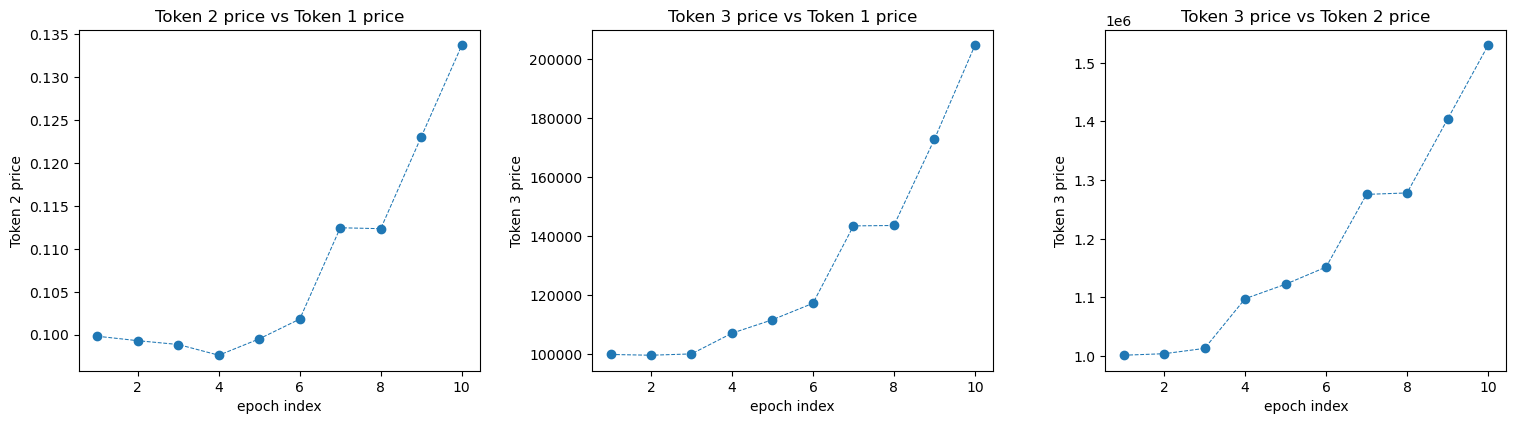

In [8]:
plotPrices(prices_list)

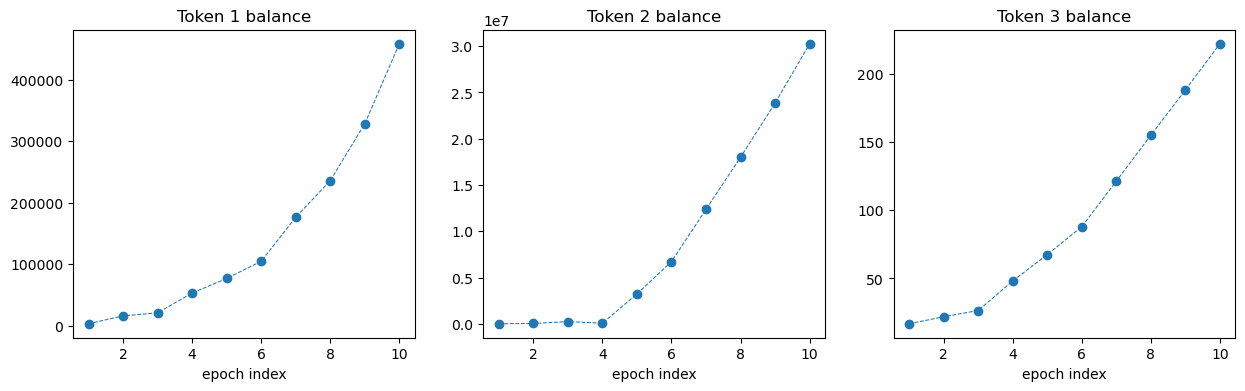

In [9]:
plotTokensBalance(baskets)

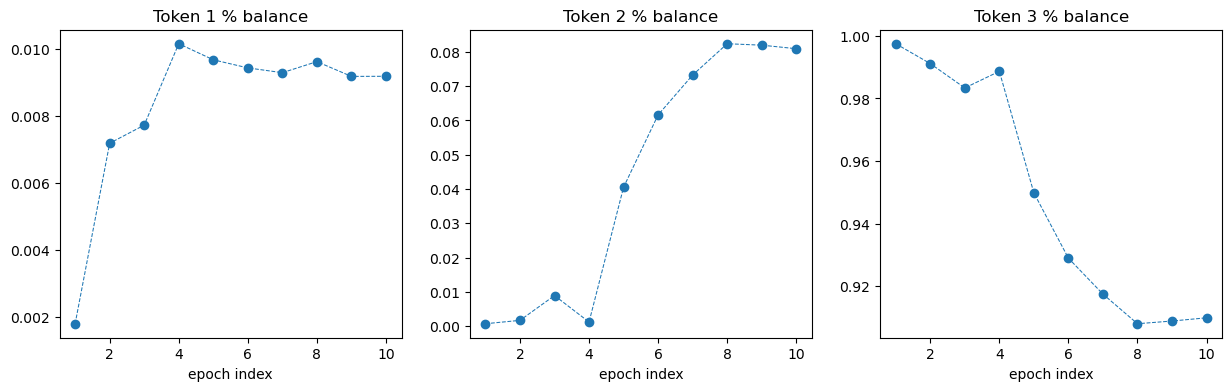

In [10]:
plotBudgetDist(baskets, prices_list)

0.0


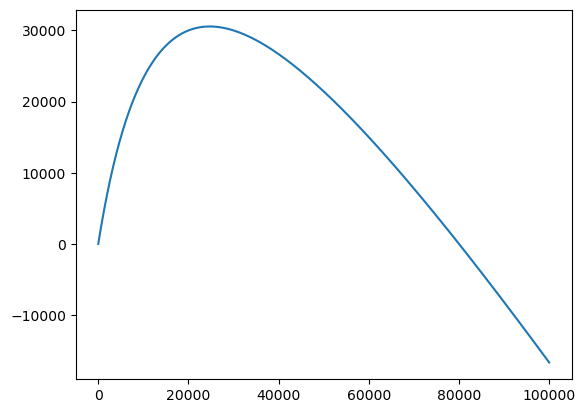

In [35]:
amm = AMM(*AMM_INIT_LIQUIDITY, AMM_FEE)
my_func = lambda x: amm.liq[0] - amm.k / (amm.liq[1] + x / (0.01 + 0.01 * 1)) / amm.liq[2] - x
v_func = np.vectorize(my_func)
x = np.linspace(0, 100000, 1000)
y = v_func(x)
print(y[0])
plt.plot(x, y);

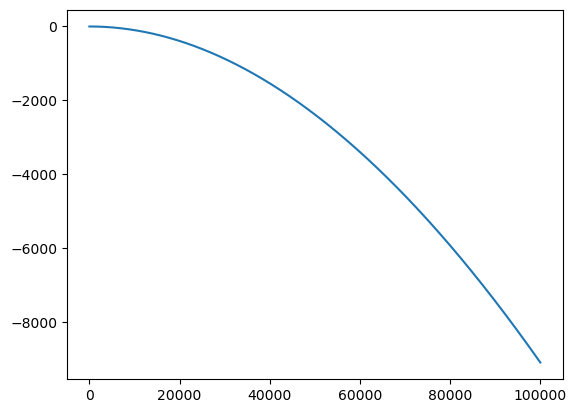

In [44]:
my_func2 = lambda x: (amm.liq[0] - amm.k / (amm.liq[1] + x) / amm.liq[2]) / (0.01 + 0.01 * 9.0) - x
v_func2 = np.vectorize(my_func2)
y2 = v_func2(x)
plt.plot(x, y2);